# Analysis of Earthquake Frequency
By Royce Schultz

## Abstract

Even leading science is unable to accuratly predict earthquakes. Instead earthquakes can be treated as a random event. Luckily, statistics has many well understood tools to understand these events.

## The exponential distribution

\begin{align}
Marginal\ Distribution = e^{-\lambda x} \\
Cumulative\ Distribution = \int MrgDist = 1 - e^{-\lambda x}
\end{align}

In [1]:
def exp_marginal_density(x, lamb): # The derivative of CDF
    return lamb * np.exp(-lamb * x)

def exp_cumulative_density(x, lamb): # The integral of MDF
    return 1 - np.exp(-lamb * x)

The exponential distribution is used to model events with a constant failure rate. That is, if the failure rate is F, 1/F events will 'fail' each timestep.


\begin{align}
TODO: Define\ and\ prove\ failure\ rate \\
\end{align}



The exponential distribution models the time **between** events, but it can be transformed to model the **number of events** in each timestep.

## The Poisson Distribution

In [2]:
def pois_marginal_density(k,lamb):
    a = lamb**k
    b = np.exp(-lamb)
    c = gamma(k+1)
    return (a * b) / c

def pois_cumulative_density(k,lamb):
    s = 0
    for x in range(k):
        s += np.exp(-lamb)*(lamb**x)/gamma(k+1)
    return s

## About the data

The dataset is available on [Kaggle](https://www.kaggle.com/usgs/earthquake-database)

The filtered set contains 23228 earthquakes from all over the world reported between 1965 and 2016. This set only contains significant earthquakes with a magnitude >5.5. There are **thousands** of small, unnoticable earthquakes every day that are not contained in this set.

| Magnitude | Effects | Estimated Number Each Year | 
|---|---|---|
| <2.5 | Usually not felt, only recorded by seismograph. | 900,000 | 
| 2.5-5.4 | Often felt, but only minor damage | 30,000 | 
|  5.5-6.0 | Slight damage to buildings | 500 | 
|  6.1-6.9 | May cause lots of damage in populated areas | 100 | 
|  7.0-7.9 | Serious Damage | 20 | 
|  >8.0 | Can totally destroy communities | 1 every 5-10 years | 

[(Source, geo.mtu.edu)](http://www.geo.mtu.edu/UPSeis/magnitude.html)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.special import gamma

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
Fields = ['Date','Time','Latitude','Longitude','Type','Magnitude','Source'] # Only import used columns
df = pd.read_csv('database.csv', usecols=Fields)

In [5]:
# Cleaning
df = df[df.Date.str.len() < 15] # Removes 3 rows with malformed dates
df = df[df.Type.isin(['Earthquake'])] # removes nuclear explosions and rock bursts

In [6]:
# Calculations
df['Datetime'] = pd.to_datetime(df.Date +' '+ df.Time) #convert strings to datetime object
df['Year'] = df['Datetime'].map(lambda x: x.year) #get year of datetime object for plotting

#for grouping magnitudes
df['Rounded_Magnitude'] = np.floor(df.Magnitude * 2) / 2 #scaling rounds to the nearest half instad of whole number.

df['Last_Quake'] = df.Datetime.diff() #get frequency data
df = df[df['Last_Quake'].notna()]
df['Last_Quake_days'] = df['Last_Quake'].map(lambda x: x.total_seconds()/(24*60*60)) # Convert to days

df.reset_index(drop=True, inplace=True)
df.head()

,Date,Time,Latitude,Longitude,Type,Magnitude,Source,Datetime,Year,Rounded_Magnitude,Last_Quake,Last_Quake_days
0,01/04/1965,11:29:49,1.863,127.352,Earthquake,5.8,ISCGEM,1965-01-04 11:29:49,1965,5.5,1 days 21:45:31,1.906609
1,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,6.2,ISCGEM,1965-01-05 18:05:58,1965,6.0,1 days 06:36:09,1.275104
2,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,5.8,ISCGEM,1965-01-08 18:49:43,1965,5.5,3 days 00:43:45,3.030382
3,01/09/1965,13:32:50,11.938,126.427,Earthquake,5.8,ISCGEM,1965-01-09 13:32:50,1965,5.5,0 days 18:43:07,0.779942
4,01/10/1965,13:36:32,-13.405,166.629,Earthquake,6.7,ISCGEM,1965-01-10 13:36:32,1965,6.5,1 days 00:03:42,1.002569


In [7]:
df.describe()

,Latitude,Longitude,Magnitude,Year,Rounded_Magnitude,Last_Quake,Last_Quake_days
count,23228.000000,23228.000000,23228.000000,23228.000000,23228.000000,23228,23228.000000
mean,1.385304,39.738244,5.882785,1992.719520,5.728194,0 days 19:37:17.121146,0.817559
std,29.929647,125.755664,0.424059,14.437895,0.402489,0 days 23:24:29.312558,0.975339
min,-77.080000,-179.997000,5.500000,1965.000000,5.500000,0 days 00:00:00,0.000000
25%,-18.719500,-76.384500,5.600000,1981.000000,5.500000,0 days 03:39:22,0.152338
50%,-3.684450,106.307500,5.700000,1994.000000,5.500000,0 days 11:42:44,0.488009
75%,24.968500,145.290250,6.000000,2005.000000,6.000000,1 days 03:07:29.500000,1.130203
max,86.005000,179.998000,9.100000,2016.000000,9.000000,10 days 05:30:13,10.229317


In [8]:
len(df)

23228

## Does the strength of an earthquake depend on the time since the last earthquake?

**Hypothesis:** Assume the earth acts like a spring, constantly storing 'elastic' energy and releasing it in burst that we call earthquakes. Then big earthquakes are the result of a large buildup of energy. If an earthquake has not been recorded for a long time, the probability of a large quake is high.

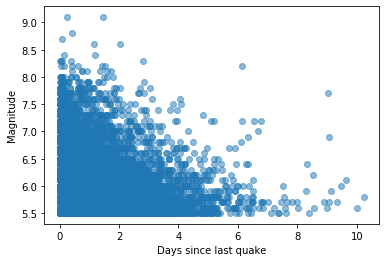

In [9]:
plt.scatter(df.Last_Quake_days,df.Magnitude, alpha=0.5)

plt.xlabel('Days since last quake')
plt.ylabel('Magnitude')
plt.show()

## Big quakes are preceeded shortly by other quakes
The hypothesis is **not supported**. In fact, the longer time without a quake, the higher probability that the next quake will be small.

However, this graph does not account for other factors like location and therefore the hypothesis cannot be proved inncorrect.

## Fitting the data to the statistical Model

Text(0.5, 0, 'Time since last Quake (days)')

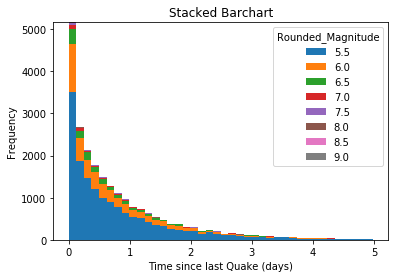

In [10]:
(df[df.Last_Quake_days < 5].pivot(columns='Rounded_Magnitude')['Last_Quake_days']).plot(kind = 'hist', stacked=True,bins=40)

plt.title('Stacked Barchart')
plt.xlabel('Time since last Quake (days)')

In [11]:
def exp_plot(density, df):
    density = 100 # Plot resolution
    lamb = []
    # This is okay becuase data is so dense. When data is more sparce, other methods must be used.

    # Cumulative Distribution
    max_x = df.Last_Quake_days.max()
    x = np.linspace(0.1,.5*max_x,density) # x does not include 0 to avoid skewing data during derivative
    y = np.zeros(density)
    for i in range(density):
        y[i] = len(df[df.Last_Quake_days < x[i]]) / len(df) # Count earthquakes less than tolerance, divide by size of list to get probability

    plt.scatter(x,y, alpha=0.5, label='Data') # Plot data

    popt, pcov = curve_fit(exp_cumulative_density, x, y) # Fit curve
    plt.plot(x, exp_cumulative_density(x, *popt), 'r-',label='Curve fit: Lambda=%5.3f' % tuple(popt)) # Plot fit curve
    lamb.append(popt)

    plt.title('Exponential Cumulative density distribution')
    plt.xlabel('Days since last quake')
    plt.ylabel('Probability')
    plt.legend()

    #Marginal Distribution
    plt.figure() # New plot
    dx = np.diff(x)
    dy = np.diff(y)
    new_x = x[1:] # becuase np.diff()

    plt.scatter(new_x,dy/dx, alpha=0.5, label='Data') # Plot data

    popt, pcov = curve_fit(exp_marginal_density, new_x, dy/dx) # Fit curve
    plt.plot(new_x, exp_marginal_density(new_x, *popt), 'r-',label='Curve fit: Lambda=%5.3f' % tuple(popt)) # Plot fit curve
    lamb.append(popt)

    plt.title('Exponential Marginal density distribution')
    plt.xlabel('Days since last quake')
    plt.ylabel('Probability')
    plt.legend()

    plt.show()
    return lamb


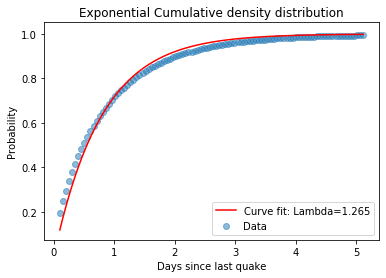

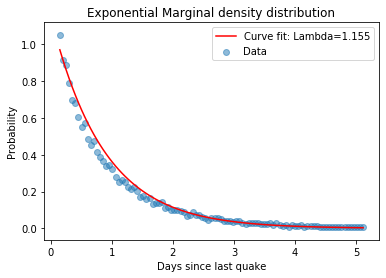

lambda (avg): 1.209864762554936


In [12]:
lamb = exp_plot(100,df)
global_lamb = np.mean(lamb)
print('lambda (avg): ' + str(global_lamb))

### Mean and Variance

The exponential distribution has the propterty,

\begin{align}
mean = \frac{1}{\lambda} \\
variance = \frac{1}{\lambda}
\end{align}

Using $\lambda = avg(1.265,1.155) = 1.210$, **on average** earthquakes occour every 0.826 days. This closely agreees with the calculated mean of the dataset with small error.

In [13]:
mean = df.Last_Quake_days.mean()
error = abs(mean - (1/global_lamb))/ mean
print('mean: %3.3f, error %3.3f' % (mean,error))

mean: 0.818, error 0.011


### Probability of a week without a strong earthquake

In [14]:
print('P(Days >= 7) = %3.3f percent' %((1 - exp_cumulative_density(7,global_lamb))*100))

P(Days >= 7) = 0.021 percent


## The Poisson Distribution

Using the lambda from the exponential distribution fitting, the Poisson distribution can be easily calcualted.

In [15]:
def pois_plot(density, df, lamb, unit, max_x=None):
    if not max_x:
        max_x = df['Last_Quake_'+unit].max()
    x = np.linspace(0,max_x,density)

    plt.plot([lamb,lamb],[0,.5], label='mean') # Mark mean
    plt.plot(x,pois_marginal_density(x,lamb),label = 'lambda=%3.3f'%(lamb))

    plt.title('Poisson Marginal Distribution')
    plt.xlabel('Earthquakes per '+unit[:-1])
    plt.ylabel('Probability')
    plt.legend()

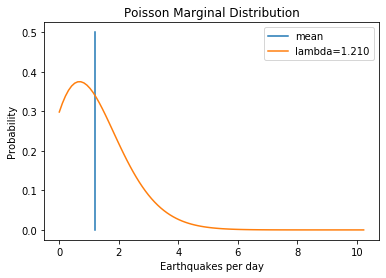

In [16]:
pois_plot(100,df,global_lamb,'days')

The Poisson distribution has the propterty,

\begin{align}
mean = \lambda \\
variance = \lambda
\end{align}

So, **on average** earth will have 1.210 eathquakes **per day**.

### Probability of 1 or more quakes in a day

In [17]:
print('P(Quake > 1) = %3.3f percent' %((1 - pois_cumulative_density(1,global_lamb))*100))

P(Quake > 1) = 70.176 percent


## Localizing the model

Earthquakes are more common at intersections of tectonic plates. Filtering the data to a local area can help residents assess and prepare for earthquakes.

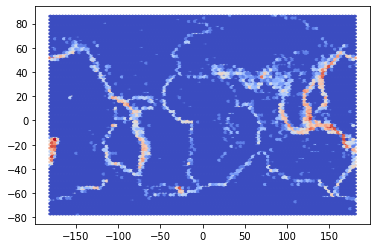

In [18]:
plt.hexbin(df.Longitude.values,df.Latitude.values, gridsize=100, bins='log',cmap='coolwarm')

### Map of tectonic plates

![Tectonic Plates Map](tectonic-plates.jpg)

## Filtering by local distance

### About the distance Funciton
Subtracting latitude and longitude of a quake will not return the distance. The data will be skewed due to the same effect that makes Greenland appear nearly as large as Africa on a 2d map.

Instead Lat/Long points define a point in spherical space and can be converted to an x,y,z triple in cartesian space. Then the euclidian distance between quakes and the reference point can be accuratly calculated.


In [19]:
# Description:
#   Determines Euclidian (straight line) between 2 points. Does not consider arc length, just straight distance
#   Assumes earth is a sphere with radius=1
#   So the poles are 2 units apart, the equator is sqrt(2) from each pole, not pi and pi/2 like it would be with arc distance
# Input:
#   Dataframe with Latitude and Longitude components
#   2 arguments for Lat and Long of reference point
# Output:
#   Series containing distances to the reference point
def distance_from(df, Lat, Long):
    Lat = np.deg2rad(Lat) # Convert degrees to radians for numpy trig
    Long = np.deg2rad(Long)
    x_pos = np.cos(Lat)*np.sin(Long) # Convert spherical coordinates to cartesian
    y_pos = np.cos(Lat)*np.cos(Long) # Assumes earths radius = 1
    z_pos = np.sin(Lat)
    
    data_Latitude_rad = np.deg2rad(df.Latitude) # Convert dataframe to radians
    data_Longitude_rad = np.deg2rad(df.Longitude)
    data_x_pos = np.cos(data_Latitude_rad)*np.sin(data_Longitude_rad) # Convert to spherical
    data_y_pos = np.cos(data_Latitude_rad)*np.cos(data_Longitude_rad)
    data_z_pos = np.sin(data_Latitude_rad)
    return ( (data_x_pos - x_pos)**2 + (data_y_pos - y_pos)**2 + (data_z_pos - z_pos)**2)**(1/2) # Pythagoras3D

### Sampling some cities

In [20]:
Tokyo = [35.67,139.65]
San_Fran = [37.77,-122.42]
Denver = [39.74,-104.99]

df['Dist_Tokyo'] = distance_from(df,Tokyo[0],Tokyo[1])
df['Dist_San_Fran'] = distance_from(df,San_Fran[0],San_Fran[1])
df['Dist_Denver'] = distance_from(df,Denver[0],Denver[1])

df.reset_index(drop=True, inplace=True)

df.head()

,Date,Time,Latitude,Longitude,Type,Magnitude,Source,Datetime,Year,Rounded_Magnitude,Last_Quake,Last_Quake_days,Dist_Tokyo,Dist_San_Fran,Dist_Denver
0,01/04/1965,11:29:49,1.863,127.352,Earthquake,5.8,ISCGEM,1965-01-04 11:29:49,1965,5.5,1 days 21:45:31,1.906609,0.612724,1.583197,1.702209
1,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,6.2,ISCGEM,1965-01-05 18:05:58,1965,6.0,1 days 06:36:09,1.275104,1.166416,1.228930,1.390338
2,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,5.8,ISCGEM,1965-01-08 18:49:43,1965,5.5,3 days 00:43:45,3.030382,1.949312,1.782142,1.726013
3,01/09/1965,13:32:50,11.938,126.427,Earthquake,5.8,ISCGEM,1965-01-09 13:32:50,1965,5.5,0 days 18:43:07,0.779942,0.459641,1.518147,1.635202
4,01/10/1965,13:36:32,-13.405,166.629,Earthquake,6.7,ISCGEM,1965-01-10 13:36:32,1965,6.5,1 days 00:03:42,1.002569,0.928365,1.334940,1.501385


### How far away can you feel a strong quake?
The [US Geological Program (USGS)](https://earthquake.usgs.gov/learn/topics/mag-intensity/) cites that even somewhat large earhquakes dissapate quickly over an area. The tremors can hardly be felt more than just 100km or about 1 degree away.

![Quake Strength Map](Quake_Strength_Heatmap.jpg)

There are clearly other factors to consider before estimating damages. Soil composition can affect energy dissapation and other secondary effects like tsunamis can cause significant damage from greater distances.

### Calculating the local distance threshold

More precicely, 100km == 0.899 deg, but lets round up to 1 degree

In [21]:
# Uses the radius of the earth to calculate the arc of 100 km

earth_radius = 6371 # kilometers
earth_circumfrence = earth_radius * 3.14 * 2
km_per_deg = earth_circumfrence / 360
print(100/km_per_deg)

0.8997777548945409


1 degree maps to 0.017 in the distance space.

In [22]:
# Calculates distance between Lat/Long points (0,0) and (0,1)

q = pd.DataFrame.from_dict({'Latitude': [0], 'Longitude': [0]})
distance_from(q,0,1)

0    0.017453
dtype: float64

For reference, the distance between San Francisco and Los Angeles is 0.088

In [23]:
# Calculate the distance (in the arbitrary distance space) between SF and LA
q = pd.DataFrame.from_dict({'Latitude': [San_Fran[0]], 'Longitude': [San_Fran[1]]})
distance_from(q,34.05,-118.24) # Distance to LA

0    0.08774
dtype: float64

## Comparing the frequency of earthquakes in 3 large cities.

Text(0.5, 1.0, 'Large earthquakes per year (avg)')

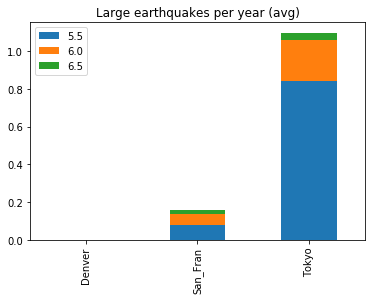

In [24]:
Local_Dist = .017
years = 2016-1965

Denver_Local_Counts = df[df.Dist_Denver < Local_Dist].Rounded_Magnitude.value_counts() / years
San_Fran_Local_Counts = df[df.Dist_San_Fran < Local_Dist].Rounded_Magnitude.value_counts() / years
Tokyo_Local_Counts = df[df.Dist_Tokyo < Local_Dist].Rounded_Magnitude.value_counts() / years

counts = pd.concat({'Denver':Denver_Local_Counts, 'San_Fran':San_Fran_Local_Counts, 'Tokyo':Tokyo_Local_Counts}, axis = 1).fillna(0)
counts.transpose().plot(kind='bar',stacked=True)

plt.title('Large earthquakes per year (avg)')


### Earthquake frequency in Tokyo

In [25]:
tokyo_df = df[df.Dist_Tokyo < Local_Dist]
# Calculations
tokyo_df['Last_Quake'] = tokyo_df.Datetime.diff()
tokyo_df = tokyo_df[tokyo_df['Last_Quake'].notna()]
tokyo_df['Last_Quake_years'] = tokyo_df['Last_Quake'].map(lambda x: x.total_seconds()/(365*24*60*60)) # Last Quake (s)

tokyo_df.reset_index(drop=True, inplace=True)
tokyo_df.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Time,Latitude,Longitude,Type,Magnitude,Source,Datetime,Year,Rounded_Magnitude,Last_Quake,Last_Quake_days,Dist_Tokyo,Dist_San_Fran,Dist_Denver,Last_Quake_years
0,09/15/1967,00:28:39,35.607,140.738,Earthquake,5.8,ISCGEM,1967-09-15 00:28:39,1967,5.5,891 days 18:56:40,1.241238,0.015472,1.199964,1.330245,2.443258
1,07/01/1968,10:45:12,35.999,139.348,Earthquake,6.1,ISCGEM,1968-07-01 10:45:12,1968,6.0,290 days 10:16:33,4.794919,0.007158,1.209596,1.336895,0.795694
2,07/22/1971,22:07:21,35.518,138.976,Earthquake,5.6,ISCGEM,1971-07-22 22:07:21,1971,5.5,1116 days 11:22:09,1.419352,0.009927,1.216899,1.344091,3.058832
3,09/30/1973,06:17:53,35.606,140.447,Earthquake,5.9,US,1973-09-30 06:17:53,1973,5.5,800 days 08:10:32,0.695035,0.011360,1.202669,1.332426,2.192714
4,10/01/1973,14:16:23,35.716,140.561,Earthquake,5.6,US,1973-10-01 14:16:23,1973,5.5,1 days 07:58:30,1.332292,0.012938,1.200728,1.330559,0.003650


In [26]:
def tokyo_plot(tokyo_df): #Redefinition of exp_plot to handle sparse data. exp_plot better handles very dense data as it doesnt plot every point.
    lamb = []
    # Cumulative Distribution
    max_x = tokyo_df.Last_Quake_years.max()
    x = np.array(sorted(tokyo_df.Last_Quake_years.values))
    y = np.arange(1,len(tokyo_df)+1)/len(tokyo_df)
    dense_x = np.linspace(0,max_x,50)

    plt.scatter(x,y, alpha=0.5, label='Data') # Plot data

    popt, pcov = curve_fit(exp_cumulative_density, x, y) # Fit curve
    plt.plot(dense_x, exp_cumulative_density(dense_x, *popt), 'r-',label='Curve fit: Lambda=%5.3f' % tuple(popt)) # Plot fit curve
    lamb.append(popt)
    
    plt.title('Exponential Cumulative density distribution')
    plt.xlabel('Years since last quake')
    plt.ylabel('Probability')
    plt.legend()


    #Marginal Distribution
    plt.figure() # New plot
    dx = np.diff(x)
    dy = np.diff(y)
    new_x = x[1:] # becuase np.diff()

    plt.scatter(new_x,dy/dx, alpha=0.5, label='Data') # Plot data

    popt, pcov = curve_fit(exp_marginal_density, new_x, dy/dx) # Fit curve
    plt.plot(dense_x, exp_marginal_density(dense_x, *popt), 'r-',label='Curve fit: Lambda=%5.3f' % tuple(popt)) # Plot fit curve
    lamb.append(popt)

    plt.title('Exponential Marginal density distribution')
    plt.xlabel('Years since last quake')
    plt.ylabel('Probability')
    plt.legend()

    plt.show()
    return lamb
    

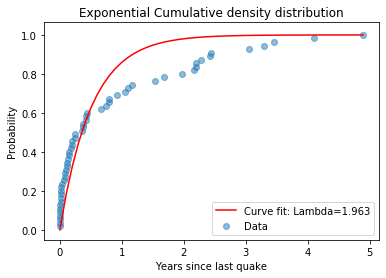

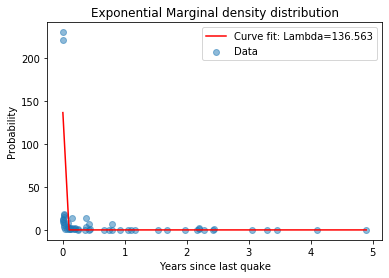

In [27]:
lamb = tokyo_plot(tokyo_df)
tokyo_lamb = lamb[0]

In [28]:
len(tokyo_df)

55

#### Fit and numerical Error

The data subset includes only 55 data points. Additionally, the marginal distribution is caluclated using a first order numerical approcimation. While the cumulative distribution has some significant apperent error, the lambda from the cumulative distribution will be used in the following calculations.

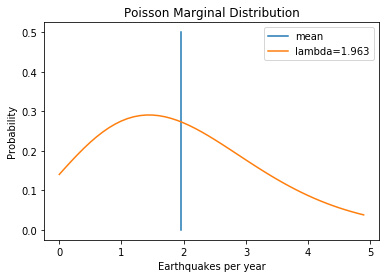

In [29]:
pois_plot(50,tokyo_df,tokyo_lamb,'years')

In [30]:
print('P(Quake > 1) = %3.3f percent' %((1 - pois_cumulative_density(1,tokyo_lamb))*100))

P(Quake > 1) = 85.959 percent


#### Tokyo Conclusions

Using the properties of Poisson distributions, Tokyo has on average **nearly 2 large earthquakes per year.** The ancient, coastal city has been built from the ground up with the danger of earthquakes in mind. Traditionally, buildings in Tokyo were made of wood becuase the wood flexes during earthquakes instead of crumbling like bricks or concrete. However, wood building cause other forms of danger. In 1923, a **8.3** magnitude earthquake hit Tokyo. A fire had broken out in one of the wooden buildings and quickly spread throughout the city killing 142,000 people, more than the earthquake itself. ([source](https://historycollection.co/day-history-great-tokyo-fire-devastates-city-1923/))

Modern structures in Tokyo use elaborate damping methods to dissapate energy as it travels through the building.

![Dampers](damper.jpg)

Other solutions completely isolate the building from the ground by sitting on rollers.

![Rollers](rollers.jpg)

### San Francisco

In [31]:
San_Fran_df = df[df.Dist_San_Fran < Local_Dist]
# Calculations
San_Fran_df['Last_Quake'] = San_Fran_df.Datetime.diff()
San_Fran_df = San_Fran_df[San_Fran_df['Last_Quake'].notna()]
San_Fran_df['Last_Quake_years'] = San_Fran_df['Last_Quake'].map(lambda x: x.total_seconds()/(365*24*60*60))

tokyo_df.reset_index(drop=True, inplace=True)
tokyo_df.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Time,Latitude,Longitude,Type,Magnitude,Source,Datetime,Year,Rounded_Magnitude,Last_Quake,Last_Quake_days,Dist_Tokyo,Dist_San_Fran,Dist_Denver,Last_Quake_years
0,09/15/1967,00:28:39,35.607,140.738,Earthquake,5.8,ISCGEM,1967-09-15 00:28:39,1967,5.5,891 days 18:56:40,1.241238,0.015472,1.199964,1.330245,2.443258
1,07/01/1968,10:45:12,35.999,139.348,Earthquake,6.1,ISCGEM,1968-07-01 10:45:12,1968,6.0,290 days 10:16:33,4.794919,0.007158,1.209596,1.336895,0.795694
2,07/22/1971,22:07:21,35.518,138.976,Earthquake,5.6,ISCGEM,1971-07-22 22:07:21,1971,5.5,1116 days 11:22:09,1.419352,0.009927,1.216899,1.344091,3.058832
3,09/30/1973,06:17:53,35.606,140.447,Earthquake,5.9,US,1973-09-30 06:17:53,1973,5.5,800 days 08:10:32,0.695035,0.011360,1.202669,1.332426,2.192714
4,10/01/1973,14:16:23,35.716,140.561,Earthquake,5.6,US,1973-10-01 14:16:23,1973,5.5,1 days 07:58:30,1.332292,0.012938,1.200728,1.330559,0.003650


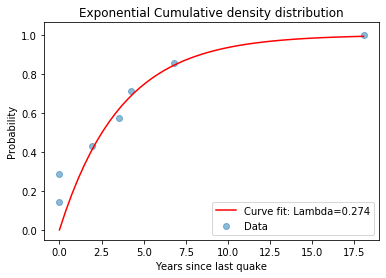

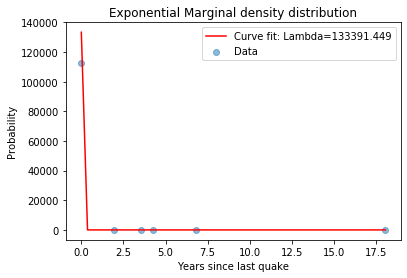

[0.27389501]


In [32]:
lamb = tokyo_plot(San_Fran_df)
San_Fran_lamb = lamb[0]
print(San_Fran_lamb)

In [33]:
len(San_Fran_df)

7

#### Fit and numerical Error

Now with even less datapoints, the numerical approximation begins to fall apart. Lambda from the cumulative distribution will be used again in the following calculations.

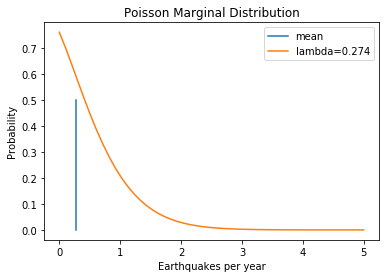

In [34]:
pois_plot(50, San_Fran_df, San_Fran_lamb,'years',5)

In [35]:
print('P(Quake > 1) = %3.3f percent' %((1 - pois_cumulative_density(1,San_Fran_lamb))*100))

P(Quake > 1) = 23.959 percent


#### San Francisco Conclusions

San Francisco has significanly less earthquakes than tokyo, but the city is not entirely safe. Residents can expect a large earthquake every 3.64 years (1/$\lambda$).

#### Is San Francisco Ready?

The coastal peninsula is largely composed of sand and other loose soils giving it a high risk of liquefaciton. Even building dampers won't help when the ground holding the foundation begins to flow like water.

![Liquefaction Map](liquefaction.png)
([source,  NY Times](https://www.nytimes.com/interactive/2018/04/17/us/san-francisco-earthquake-seismic-gamble.html))